In [8]:
import MySQLdb as mdb
import numpy as np
import csv
import sys
sys.path.append("../src/")
from src.fingerprint import Fingerprint
from src import CSV_DELIMITER

import pandas as pd
import matplotlib.pyplot as plt

DATA_PATH_REL = "../../data/"

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [9]:
# Exclusion of some attributes
ATTRIBUTES_TO_EXCLUDE = [Fingerprint.COUNTER, Fingerprint.CREATION_TIME, Fingerprint.END_TIME, Fingerprint.CONSISTENT]

In [10]:
# read the file
df = pd.read_csv(DATA_PATH_REL + "processed/fingerprint_dataset.csv", delimiter=CSV_DELIMITER, engine="python")

In [11]:
# Analysis of consistent fingerprints
attributes_to_analyze = [attribute for attribute in df.columns.tolist() if attribute not in ATTRIBUTES_TO_EXCLUDE]
df_consistent = df[df[Fingerprint.CONSISTENT] == True ]
print("There are {:d} elements in df_consistent".format(len(df_consistent)))

There are 49271 elements in df_consistent


In [12]:
# Name of attributes
print(df_consistent.columns, "There are {:d} columns in df_consistent".format(len(df_consistent.columns)))

Index(['counter', 'id', 'creationDate', 'endDate', 'addressHttp',
       'userAgentHttp', 'acceptHttp', 'connectionHttp', 'encodingHttp',
       'languageHttp', 'orderHttp', 'pluginsJSHashed', 'platformJS',
       'cookiesJS', 'dntJS', 'timezoneJS', 'resolutionJS', 'localJS',
       'sessionJS', 'canvasJSHashed', 'fontsFlashHashed', 'resolutionFlash',
       'languageFlash', 'platformFlash', 'browserFamily',
       'globalBrowserVersion', 'minorBrowserVersion', 'majorBrowserVersion',
       'os', 'rendererWebGLJS', 'vendorWebGLJS', 'consistent'],
      dtype='object') There are 32 columns in df_consistent


In [6]:
# Visualization of the first 5 lines
df_consistent.head(5)

,counter,id,creationDate,endDate,addressHttp,userAgentHttp,acceptHttp,connectionHttp,encodingHttp,languageHttp,...,languageFlash,platformFlash,browserFamily,globalBrowserVersion,minorBrowserVersion,majorBrowserVersion,os,rendererWebGLJS,vendorWebGLJS,consistent
15,17,0f4f77e3-80da-4b4a-b9c0-f5e8c4239380,2015-07-27 11:00:00,None,24f5398bba446ce8dadfd3d23ca2f4e58895e76e,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,"text/html,application/xhtml+xml,application/xm...",close,"gzip, deflate, sdch","en-US,en;q=0.8,fr;q=0.6",...,en,Linux,Chrome,440,0,44,Linux,Mesa DRI Intel(R) Haswell Mobile,Intel Open Source Technology Center,True
17,19,74bf8f6f-0114-44b4-9bca-1cfc52ffc2d3,2015-07-27 12:00:00,None,24f5398bba446ce8dadfd3d23ca2f4e58895e76e,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,"text/html,application/xhtml+xml,application/xm...",close,"gzip, deflate, sdch","en-US,en;q=0.8,fr;q=0.6",...,en,Linux,Chrome,440,0,44,Linux,Mesa DRI Intel(R) Haswell Mobile,Intel Open Source Technology Center,True
18,20,df46c5fb-9889-4ff4-9f51-e5af591f3460,2015-07-27 12:00:00,None,24f5398bba446ce8dadfd3d23ca2f4e58895e76e,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,"text/html,application/xhtml+xml,application/xm...",close,"gzip, deflate, sdch","en-US,en;q=0.8,fr;q=0.6",...,en,Linux,Chrome,440,0,44,Linux,Mesa DRI Intel(R) Haswell Mobile,Intel Open Source Technology Center,True
19,21,dc031028-a4ea-4ce8-a362-17b07a4f4d65,2015-07-27 12:00:00,2015-07-28 11:00:00,90f2974eff1d1b3f05d01f413cf0241fae23352e,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_4...,"text/html,application/xhtml+xml,application/xm...",close,"gzip, deflate, sdch","fr-FR,fr;q=0.8,en-US;q=0.6,en;q=0.4",...,fr,Mac OS 10.10.4,Chrome,440,0,44,Mac OS X,Intel HD Graphics 5000 OpenGL Engine,Intel Inc.,True
20,22,d51d09c6-2596-4958-bfe7-0352af2aaccf,2015-07-27 12:00:00,2015-07-29 06:00:00,2515ee56512877237d467911f5c55be53eea3550,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,"text/html,application/xhtml+xml,application/xm...",close,"gzip, deflate, sdch","fr-FR,fr;q=0.8,en-US;q=0.6,en;q=0.4",...,en,Linux,Chrome,430,0,43,Linux,Not supported,Not supported,True


In [7]:
print("Statistics on dataset filtered: only consistent browsers")
for attribute in attributes_to_analyze:
    nb_distinct_values = df_consistent[attribute].value_counts().count()
    print("{} : {:d} distinct values".format(attribute, nb_distinct_values))

Statistics on dataset filtered: only consistent browsers
id : 4651 distinct values
addressHttp : 15781 distinct values
userAgentHttp : 2289 distinct values
acceptHttp : 7 distinct values
connectionHttp : 1 distinct values
encodingHttp : 12 distinct values
languageHttp : 424 distinct values
orderHttp : 114 distinct values
pluginsJSHashed : 4247 distinct values
platformJS : 17 distinct values
cookiesJS : 2 distinct values
dntJS : 2 distinct values
timezoneJS : 33 distinct values
resolutionJS : 446 distinct values
localJS : 2 distinct values
sessionJS : 2 distinct values
canvasJSHashed : 938 distinct values
fontsFlashHashed : 4684 distinct values
resolutionFlash : 257 distinct values
languageFlash : 27 distinct values
platformFlash : 222 distinct values
browserFamily : 18 distinct values
globalBrowserVersion : 78 distinct values
minorBrowserVersion : 21 distinct values
majorBrowserVersion : 43 distinct values
os : 14 distinct values
rendererWebGLJS : 489 distinct values
vendorWebGLJS : 13

In [45]:
# Détection of inconsistent values
df_consistent[df_consistent[Fingerprint.MAJOR_BROWSER_VERSION]== "None"]["userAgentHttp"]

6203                                                   NaN
10095    this is a test ua &lt;img src=x onerror= alert...
20843                                                  NaN
38964                                                  NaN
44062                                                  NaN
45033                       xChaos_Arachne/5.1.89;GPL,386+
52521    Mozilla/5.0 (PlayStation 4 3.15) AppleWebKit/5...
59961    Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:4...
71595                                                  NaN
72843                                                  NaN
87820                                                  NaN
Name: userAgentHttp, dtype: object

In [46]:
# N° of the fingerprint to take off it from consistent fingerprints
df_consistent[df_consistent[Fingerprint.MAJOR_BROWSER_VERSION] == "None"]["counter"]

6203       7843
10095     12782
20843     26534
38964     49758
44062     56618
45033     57934
52521     67757
59961     77378
71595     93843
72843     95707
87820    118549
Name: counter, dtype: int64

In [61]:
# entropy
def compute_entropy(df, attribute):
    entropy = 0
    serie = df[attribute].value_counts()
    
    if len(serie) == 1:
        return 0
    
    total_values = serie.sum()
    for index, value in serie.iteritems():
        pi = float(value)/float(total_values)
        entropy += pi * np.log2(pi)
    
    return -entropy

def compute_normalized_entropy(df, attribute):
    number_distinct = df[attribute].value_counts().sum()
    
    if number_distinct == 1:
        return 0
    
    pi_worst = 1.0 / float(number_distinct)
    worst_case = -number_distinct * pi_worst * np.log2(pi_worst)
    
    df[attribute].value_counts().count()
    entropy = compute_entropy(df, attribute)
    return entropy / worst_case


print("Entropy on dataset filtered: only consistent browsers")
for attribute in attributes_to_analyze:
    entropy = compute_normalized_entropy(df_consistent, attribute)
    print("{} : {:f} bits".format(attribute, entropy))

Entropy on dataset filtered: only consistent browsers
id : 0.655848 bits
addressHttp : 0.785361 bits
userAgentHttp : 0.567186 bits
acceptHttp : 0.062577 bits
connectionHttp : 0.000000 bits
encodingHttp : 0.116758 bits
languageHttp : 0.326656 bits
orderHttp : 0.185542 bits
pluginsJSHashed : 0.530793 bits
platformJS : 0.099387 bits
cookiesJS : 0.004120 bits
dntJS : 0.063202 bits
timezoneJS : 0.208508 bits
resolutionJS : 0.248285 bits
localJS : 0.022550 bits
sessionJS : 0.022331 bits
canvasJSHashed : 0.427145 bits
fontsFlashHashed : 0.492978 bits
resolutionFlash : 0.232937 bits
languageFlash : 0.163492 bits
platformFlash : 0.230398 bits
browserFamily : 0.076352 bits
globalBrowserVersion : 0.258192 bits
minorBrowserVersion : 0.005404 bits
majorBrowserVersion : 0.256442 bits
os : 0.160001 bits
rendererWebGLJS : 0.297902 bits
vendorWebGLJS : 0.133481 bits


In [24]:
# terms : effective, %
# number of unique terms
# most common terms
def analyse_terms(df, attribute):
    tmp_stats = []
    ids = set(df_consistent['id'].unique())
    for user_id in ids:
        df_user_id = df_consistent[df_consistent['id'] == user_id]
        different_values = df_user_id[attribute].unique()
        for value in different_values:
            tmp_stats.append({
                "id": user_id,
                attribute : value
            })
    df_stats = pd.DataFrame(tmp_stats)
    
    nb = df_stats[attribute].value_counts()
    df_nb = pd.DataFrame(nb)
    
    nb_percent = nb/nb.sum()*100
    df_nb_percent = pd.DataFrame(nb_percent)
    
    tab = df_nb.join(df_nb_percent, lsuffix='_left', rsuffix='_right')
    tab.columns = ['effective', '%']
    
    
    print(tab)
    print()
    
    df_nb_percent.plot(kind='barh', stacked=False, width=0.9)
    plt.xlim(0, 100)
    plt.gca().invert_yaxis() 
    plt.show()
    
    print("There are {:d} unique terms for the attribute '{}'".format(len(nb[nb.values == 1]), attribute))
    print()
    print("The most used terms are: \n{}".format(nb[:5]))

               effective          %
Windows 7           1405  30.208557
Windows 10          1218  26.187917
Mac OS X             566  12.169426
Linux                494  10.621372
Windows 8.1          380   8.170286
Ubuntu               303   6.514728
Windows XP           112   2.408084
Chrome OS             71   1.526553
Windows 8             55   1.182541
Windows Vista         23   0.494517
Other                 12   0.258009
OpenBSD                7   0.150505
FreeBSD                4   0.086003
NetBSD                 1   0.021501



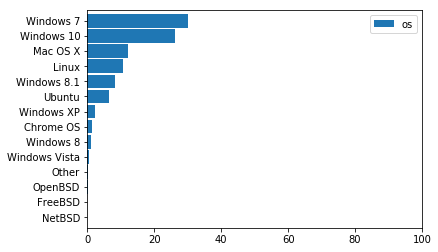

There are 1 unique terms for the attribute 'os'

The most used terms are: 
Windows 7      1405
Windows 10     1218
Mac OS X        566
Linux           494
Windows 8.1     380
Name: os, dtype: int64


In [44]:
analyse_terms(df_consistent, 'os')

In [52]:
def analyze_headers_http_1(df, attribute, group_by_attribute):
    tmp_stats = []
    ids = set(df_consistent['id'].unique())
    for user_id in ids:
        df_user_id = df_consistent[df_consistent['id'] == user_id]
        os_user = df_user_id["os"].values[0]
        browser_user = df_user_id["browserFamily"].values[0]

        different_values = df_user_id[attribute].unique()
        for value in different_values:
            tmp_stats.append({
                "id": user_id,
                "os": os_user,
                "browserFamily": browser_user
            })
    df_stats = pd.DataFrame(tmp_stats)
    
    stats_grouped = df_stats.groupby([attribute,group_by_attribute]).size()
    stats_grouped_sorted = stats_grouped.sort_values(ascending = False)

    print(stats_grouped_sorted)

In [51]:
analyze_headers_http_1(df_consistent, 'browserFamily', 'os')

browserFamily                os           
Chrome                       Chrome OS         71
                             FreeBSD            1
                             Linux            265
                             Mac OS X         370
                             OpenBSD            3
                             Windows 10       677
                             Windows 7        516
                             Windows 8         21
                             Windows 8.1       96
                             Windows Vista      8
                             Windows XP         6
Chromium                     Ubuntu            67
Dragon                       Windows 10         4
                             Windows 7          2
                             Windows 8.1        3
Epiphany                     Ubuntu             2
Firefox                      FreeBSD            3
                             Linux            176
                             Mac OS X         186
       

In [28]:
def analyze_headers_http(df, attribute, group_by_attribute, split_function):
    tmp_dataset = []
    tmp_stats = []
    ids = set(df_consistent['id'].unique())
    for user_id in ids:
        df_user_id = df_consistent[df_consistent['id'] == user_id]
        os_user = df_user_id["os"].values[0]
        browser_user = df_user_id["browserFamily"].values[0]

        different_values = df_user_id[attribute].unique()
        for value in different_values:
            tmp_stats.append({
                "id": user_id,
                "os": os_user,
                "browserFamily": browser_user
            })
            values_split = split_function(value)

            for value_tmp in values_split:
                tmp_dataset.append({
                    "id": user_id,
                    "os": os_user,
                    "browserFamily": browser_user,
                    attribute: value_tmp

                })

    df_tmp = pd.DataFrame(tmp_dataset)
    df_stats = pd.DataFrame(tmp_stats)
    stats_grouped = df_stats[group_by_attribute].value_counts()
    
    grouped = df_tmp.groupby([attribute])
    for name, group in grouped:
        norm = 0 
        count_per_group = group[group_by_attribute].value_counts()
        for key, number in stats_grouped.iteritems():
            try:
                norm += (number - count_per_group[key])**2
            except KeyError:
                norm += number**2

        if norm >= 0:
            print(name)
            print(count_per_group)

        print(norm)

def split_headers(headers):
    return headers.split(" ")

def split_languages_http(languages):
    try:
        return languages.split(";")
    except AttributeError:
        return str(languages)
    
def split_accept_http(accept):
    return accept.split(",")

def split_nothing(attribute):
    return attribute


In [29]:
analyze_headers_http(df_consistent, "os", "browserFamily", split_nothing)

 
Firefox                        2162
Chrome                         2135
Vivaldi                          33
Iron                             31
Opera                            15
Dragon                            9
Yandex Browser                    5
Pale Moon (Firefox Variant)       2
SeaMonkey                         2
Other                             1
Maxthon                           1
Name: browserFamily, dtype: int64
71007
.
Firefox                        275
Chrome                          96
Iron                             4
Dragon                           3
Pale Moon (Firefox Variant)      1
Vivaldi                          1
Name: browserFamily, dtype: int64
8267039
0
Chrome            677
Firefox           502
Vivaldi            18
Iron               13
Dragon              4
Opera               2
Yandex Browser      1
Other               1
Name: browserFamily, dtype: int64
5439167
1
Firefox                        777
Chrome                         773
Vivaldi         

In [137]:
pd.DataFrame(df_consistent['os'].unique())

,0
0,Linux
1,Mac OS X
2,Ubuntu
3,Windows 7
4,Windows 10
5,Windows 8.1
6,Windows XP
7,Windows 8
8,Windows Vista
9,Chrome OS


In [152]:
tmp_stats = []
ids = set(df_consistent['id'].unique())
for user_id in ids:
    df_user_id = df_consistent[df_consistent['id'] == user_id]
    different_values = df_user_id['browserFamily'].unique()
    for value in different_values:
        tmp_stats.append({
            "id": user_id,
            'browserFamily' : value
        })
df_stats = pd.DataFrame(tmp_stats)

nb = df_stats['browserFamily'].value_counts()
df_nb = pd.DataFrame(nb)

nb_percent = nb/nb.sum()*100
df_nb_percent = pd.DataFrame(nb_percent)

In [161]:
df_nb_percent

,browserFamily
Firefox,51.537304
Chrome,43.732531
Chromium,1.440550
Vivaldi,0.881531
Iron,0.731026
Iceweasel,0.666523
Opera,0.322511
Dragon,0.193507
Other,0.172006
Yandex Browser,0.107504


In [182]:
df_consistent['id'].value_counts()

c3af36ba-81f4-4652-9523-44f2217dc0f0    828
2bef0281-b2d9-41ac-967c-45835e5ba8c0    658
efca79c2-0b12-4ce7-a28f-68ad9193990d    643
77aae6f6-0bbd-4138-baa4-142c1e4dddcd    534
bc19c32d-a271-4dd7-b5e6-62d36d1a3128    498
f61809d2-a428-4a2c-81e4-461ea9908687    429
d4be492d-c9ee-46a0-b1ab-076386b61b85    411
68942969-0475-4a26-931b-d1d8043a659c    370
31fa27b8-6c4d-47b2-8566-b4af4d9ca9e8    368
c17f5405-360e-43d7-9b50-bccf6faf2207    312
ac7c0dae-6fe3-48e3-97b7-ab62571a0eb1    268
b8f4eb79-baaf-442b-ada2-5bcd5cf89df4    268
f4f25187-82c7-4265-9bf9-71bc8ed1701f    266
907af844-581a-4044-8ddb-8bcc91df32f9    264
d7969eaf-cd67-4ac5-b060-393d864f8525    253
c28aa37d-571e-4b43-bf01-aa14eeb765e7    246
2f38656b-76d5-4b46-a81d-c90b96495673    233
7a26546e-0a07-423c-9e97-0ef56212920d    232
893c10a4-b913-4fd9-a2a6-6a0ea7a1cc62    229
39107c52-98c9-4a75-b505-271294fac465    224
628a06f1-ca1e-4e6e-9b38-5e23da554b53    194
a5f01fef-bcda-49d6-b726-2fe0d7a4e928    172
f258256f-54bc-46fc-baca-9df34d5f

In [181]:
df_consistent[df_consistent[Fingerprint.ID] == "c3af36ba-81f4-4652-9523-44f2217dc0f0"]

,counter,id,creationDate,endDate,addressHttp,userAgentHttp,acceptHttp,connectionHttp,encodingHttp,languageHttp,...,languageFlash,platformFlash,browserFamily,globalBrowserVersion,minorBrowserVersion,majorBrowserVersion,os,rendererWebGLJS,vendorWebGLJS,consistent
47428,61081,c3af36ba-81f4-4652-9523-44f2217dc0f0,2016-08-17 06:00:00,2016-08-21 11:00:00,f460c3564ba0691863d70c4e3d17f1e70f18b9da,Mozilla/5.0 (Windows NT 6.3; WOW64; rv:47.0) G...,"text/html,application/xhtml+xml,application/xm...",close,"gzip, deflate, br","en-US,en;q=0.5",...,ru,Windows 8.1,Firefox,470,0,47,Windows 8.1,Not supported,Not supported,True
48291,62237,c3af36ba-81f4-4652-9523-44f2217dc0f0,2016-08-21 11:00:00,2016-08-21 12:00:00,efe6ca1d3bd806b4d110e89921a027605c146445,Mozilla/5.0 (Windows NT 6.3; WOW64; rv:47.0) G...,"text/html,application/xhtml+xml,application/xm...",close,"gzip, deflate, br","en-US,en;q=0.5",...,ru,Windows 8.1,Firefox,470,0,47,Windows 8.1,Not supported,Not supported,True
48302,62252,c3af36ba-81f4-4652-9523-44f2217dc0f0,2016-08-21 12:00:00,2016-08-22 12:00:00,2b6cc41cd5f82b4e561288acba06bd6fd735e256,Mozilla/5.0 (Windows NT 6.3; WOW64; rv:47.0) G...,"text/html,application/xhtml+xml,application/xm...",close,"gzip, deflate, br","en-US,en;q=0.5",...,ru,Windows 8.1,Firefox,470,0,47,Windows 8.1,Not supported,Not supported,True
48497,62514,c3af36ba-81f4-4652-9523-44f2217dc0f0,2016-08-22 12:00:00,2016-08-22 12:00:00,1067aed7c3e8ce6cf160d9c7ecf87a95c2357c1d,Mozilla/5.0 (Windows NT 6.3; WOW64; rv:47.0) G...,"text/html,application/xhtml+xml,application/xm...",close,"gzip, deflate, br","en-US,en;q=0.5",...,ru,Windows 8.1,Firefox,470,0,47,Windows 8.1,Not supported,Not supported,True
48503,62521,c3af36ba-81f4-4652-9523-44f2217dc0f0,2016-08-22 12:00:00,2016-08-22 13:00:00,04db8f4d863ee800f5be2d4dce33ef50d48639f3,Mozilla/5.0 (Windows NT 6.3; WOW64; rv:47.0) G...,"text/html,application/xhtml+xml,application/xm...",close,"gzip, deflate, br","en-US,en;q=0.5",...,ru,Windows 8.1,Firefox,470,0,47,Windows 8.1,Not supported,Not supported,True
48511,62532,c3af36ba-81f4-4652-9523-44f2217dc0f0,2016-08-22 13:00:00,2016-08-22 13:00:00,ad9b16e1722b38c8f95d3e1496f61357a937efa0,Mozilla/5.0 (Windows NT 6.3; WOW64; rv:47.0) G...,"text/html,application/xhtml+xml,application/xm...",close,"gzip, deflate, br","en-US,en;q=0.5",...,ru,Windows 8.1,Firefox,470,0,47,Windows 8.1,Not supported,Not supported,True
48513,62534,c3af36ba-81f4-4652-9523-44f2217dc0f0,2016-08-22 13:00:00,2016-08-22 13:00:00,04db8f4d863ee800f5be2d4dce33ef50d48639f3,Mozilla/5.0 (Windows NT 6.3; WOW64; rv:47.0) G...,"text/html,application/xhtml+xml,application/xm...",close,"gzip, deflate, br","en-US,en;q=0.5",...,ru,Windows 8.1,Firefox,470,0,47,Windows 8.1,Not supported,Not supported,True
48518,62539,c3af36ba-81f4-4652-9523-44f2217dc0f0,2016-08-22 13:00:00,2016-08-22 15:00:00,84ec97716818b57ab2b9d158707aad9d407bf274,Mozilla/5.0 (Windows NT 6.3; WOW64; rv:47.0) G...,"text/html,application/xhtml+xml,application/xm...",close,"gzip, deflate, br","en-US,en;q=0.5",...,ru,Windows 8.1,Firefox,470,0,47,Windows 8.1,Not supported,Not supported,True
48551,62576,c3af36ba-81f4-4652-9523-44f2217dc0f0,2016-08-22 15:00:00,2016-08-22 15:00:00,f8a9ea6212825b9343a67d48379bb555f9295546,Mozilla/5.0 (Windows NT 6.3; WOW64; rv:47.0) G...,"text/html,application/xhtml+xml,application/xm...",close,"gzip, deflate, br","en-US,en;q=0.5",...,ru,Windows 8.1,Firefox,470,0,47,Windows 8.1,Not supported,Not supported,True
48552,62578,c3af36ba-81f4-4652-9523-44f2217dc0f0,2016-08-22 15:00:00,2016-08-23 13:00:00,04db8f4d863ee800f5be2d4dce33ef50d48639f3,Mozilla/5.0 (Windows NT 6.3; WOW64; rv:47.0) G...,"text/html,application/xhtml+xml,application/xm...",close,"gzip, deflate, br","en-US,en;q=0.5",...,ru,Windows 8.1,Firefox,470,0,47,Windows 8.1,Not supported,Not supported,True
